<a href="https://colab.research.google.com/github/DavidMCV97/debt_classification/blob/debt_analysis_1/BBVA_debt_classification_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBVA debt classification
This is the second model we'll use for the debt classification of BBVA. Somo of the steps are similar to the first model *BBVA discounts analysis* \\
First we import some libraries and mount the google drive files.

In [ ]:
from google.colab import drive # to mount drive files
import pandas as pd # for dataframes
import numpy as np # for numerical processes
import matplotlib.pyplot as plt # for graphs

In [ ]:
drive.mount('/content/drive') # we make available the drive files

Mounted at /content/drive


Second we import the discounts base, correct the data types and clean it.

In [ ]:
base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_activities(no_pilot).csv')
base.inicio_programa = pd.to_datetime(base.inicio_programa,format='%Y-%m-%d',errors='coerce') # errors in cast will be NaT
base.ultimo_pago = pd.to_datetime(base.ultimo_pago,format='%Y-%m-%d',errors='coerce')
base.executed_date = pd.to_datetime(base.executed_date,format='%Y-%m-%d',errors='coerce')
base[['bank_reference','debt_id','banco','num_tarjeta']] = base[['bank_reference','debt_id','banco','num_tarjeta']].astype(str) #simultaneous cast
base.drop(base[base.isnull().any(axis=1)].index,inplace=True) #drop rows with null or NaT values
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bank_reference   21854 non-null  object        
 1   debt_id          21854 non-null  object        
 2   banco            21854 non-null  object        
 3   num_tarjeta      21854 non-null  object        
 4   deuda_resuelve   21854 non-null  float64       
 5   inicio_programa  21854 non-null  datetime64[ns]
 6   ultimo_pago      21854 non-null  datetime64[ns]
 7   executed_date    21854 non-null  datetime64[ns]
 8   pago_a_bancos    21854 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 1.5+ MB


Third, we add the bins to the base and merge them with the bin intrest rate. \\
We'll drop the wrong bank type so please specify the bank type imput and default interest rate

In [ ]:
bank_input = 'card' # imput card or loan
default_interest_rate = 0.04

In [ ]:
cards = base.num_tarjeta.str.replace('\D','',regex=True)
cards_len = cards.str.len()
base['bank_type'] = np.where((cards_len >= 15)&(cards_len <= 17), 'card','loan')
base['Bin'] = cards.str[:6]
base = base[base.bank_type == bank_input]

In [ ]:
bins = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_bins.csv')
bins = pd.DataFrame(bins)
bins['Bin'] = bins['Bin'].astype(str)
bins = bins.drop_duplicates('Bin')

In [ ]:
base = pd.merge(base, bins, on = 'Bin', how = 'left')

In [ ]:
base.tasa = base.tasa.fillna(default_interest_rate)
base[['debt_id','Bin','tasa']].sample(10)

,debt_id,Bin,tasa
690,618481,477214,0.0375
7839,1305308,477291,0.0375
6246,1279950,477214,0.0375
7229,1294705,554629,0.0400
1845,1270989,542015,0.0375
7230,1304374,542015,0.0375
8153,1313020,477213,0.0375
5352,1255732,477213,0.0375
9850,1394137,477291,0.0375
6307,1273311,477213,0.0375


Fourth, we calculate the balance and discount. Please specify the max period of interest grow.

In [ ]:
max_period = 18 #max period of interest grow
tolerance_rate = 3 # max number of times a payment can be bigger than the original debt,
                   # bigger values will be considered mistakes
max_discount = 0.99 #discounts bigger than this will be considered mistakes

In [ ]:
base['deliq_beginning_prog'] = (base.inicio_programa.dt.year - base.ultimo_pago.dt.year)*12 + base.inicio_programa.dt.month - base.ultimo_pago.dt.month
base.deliq_beginning_prog = np.where(base.deliq_beginning_prog < 0, 0, base.deliq_beginning_prog)
base['deliq_act'] = (base.executed_date.dt.year - base.ultimo_pago.dt.year)*12 + base.executed_date.dt.month - base.ultimo_pago.dt.month
base.drop(base[base.deliq_act <0].index,inplace=True) # we drop negative periods as there must be a payment after the discount
base['aux_balance'] = np.where(base.deliq_beginning_prog > max_period, 0,
                      np.where(base.deliq_act > max_period, max_period - base.deliq_beginning_prog,
                               base.deliq_act - base.deliq_beginning_prog))
base['balance'] = base.deuda_resuelve*(1 + base.tasa)**(base.aux_balance)
base['real_discount'] = 1-base.pago_a_bancos/base.balance
base.drop(base[base.deuda_resuelve*tolerance_rate < base.pago_a_bancos].index, inplace = True)
base.drop(base[base.real_discount > max_discount].index,inplace=True)
base[['debt_id','deuda_resuelve','pago_a_bancos','tasa','aux_balance','balance','real_discount']].sample(10)

,debt_id,deuda_resuelve,pago_a_bancos,tasa,aux_balance,balance,real_discount
6995,1286627,102572.44,45608.0,0.0375,4,118845.600178,0.616242
4406,1234655,26465.59,3489.0,0.0375,8,35529.281363,0.901799
3289,1197655,35464.86,28761.0,0.0375,6,44231.012611,0.349755
6242,1272469,71176.65,8122.0,0.0375,4,82468.855064,0.901514
5711,1261698,52000.59,18059.0,0.0375,5,62509.899130,0.711102
8347,1319206,38545.00,13450.0,0.0400,5,46895.886123,0.713194
3735,1213766,3600.00,1420.0,0.0375,6,4489.842774,0.683731
3542,1206658,28795.75,4322.0,0.0375,7,37260.195746,0.884005
9417,1358322,19450.67,6378.0,0.0375,2,20936.822755,0.695369
2689,1169142,19919.17,6600.0,0.0375,8,26740.903772,0.753187


Let's see how the discounts look!

(0.0, 22.0)

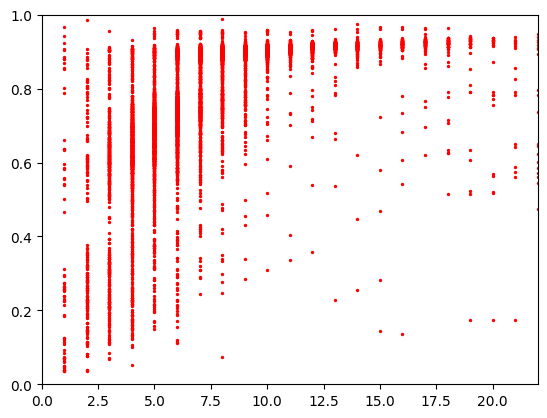

In [ ]:
plt.scatter(base.deliq_act,base.real_discount, s = 2, color = 'red')
plt.ylim(0,1) # y axis size
plt.xlim(0,22) # x axis size

Now we'll group discounts by debt, ordered from newest to oldest

In [ ]:
n_act = 4 #number of activities to analize for each debt

In [ ]:
base['ranking'] = base.groupby(by='debt_id')['executed_date'].rank(ascending=False) # rank function enumerate conditional subsets
debts = base[['debt_id']].drop_duplicates() # the duble brackets [[]] let us keep the column as dataframe
for i in reversed(range(1,n_act + 1)): #range goes from 0 to n-1, thats why we need to specify begginning and end + 1
  ranking = base[base.ranking == i][['debt_id','deliq_act','real_discount']]
  ranking[i] = list(zip(ranking.deliq_act,ranking.real_discount))
  debts = pd.merge(debts,ranking[['debt_id',i]],on='debt_id',how='left').fillna('no_act')

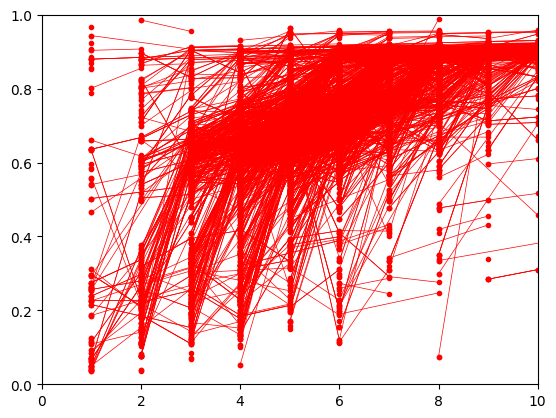

In [ ]:
for i in debts.index:
  X = np.full(n_act,np.nan)
  Y = np.full(n_act,np.nan)
  j = 0
  for dot in debts.loc[i,reversed(range(1,n_act+1))]:
    if dot != 'no_act':
      X[j] = dot[0]
      Y[j] = dot[1]
    j = j + 1

    plt.plot(X,Y,color = 'red', marker = '.',linewidth=0.5)
plt.ylim(0,1) # y axis size
plt.xlim(0,10) # x axis size
plt.show()

We'll describe the behavior of the activities until month 22 with a logarithmic regression

In [ ]:
fit = np.polyfit(np.log(base.deliq_act),base.real_discount,1)

In [ ]:
def log_reg(x): return fit[0]*np.log(x) + fit[1]

(0.0, 22.0)

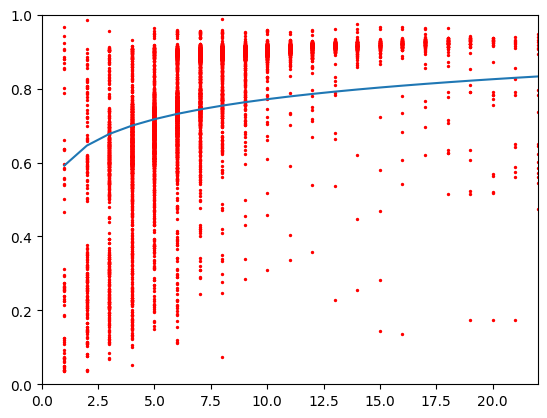

In [ ]:
x = np.linspace(1,23,23)
plt.plot(x,log_reg(x))
plt.scatter(base.deliq_act,base.real_discount, s = 2, color = 'red')
plt.ylim(0,1) # y axis size
plt.xlim(0,22) # x axis size

In [ ]:
log_reg(x)

array([0.59160821, 0.64569999, 0.67734165, 0.69979177, 0.71720543,
       0.73143343, 0.74346303, 0.75388354, 0.76307509, 0.7712972 ,
       0.77873501, 0.7855252 , 0.79177157, 0.7975548 , 0.80293886,
       0.80797532, 0.81270634, 0.81716686, 0.82138616, 0.82538898,
       0.82919646, 0.83282679, 0.83629571])